<a href="https://colab.research.google.com/github/Soham0410/Sentimental-Analysis/blob/main/Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install kaggle

In [ ]:
# Configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading the dataset
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
dataset = 'sentiment140.zip'
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [ ]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Data processing
socialmedia_data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

In [ ]:
# Naming columns
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
socialmedia_data = pd.read_csv('training.1600000.processed.noemoticon.csv', names=column_names, encoding='ISO-8859-1')

In [ ]:
# Replace target values
socialmedia_data.replace({'target': {4: 1}}, inplace=True)

In [ ]:
# Initialize PorterStemmer
port_stem = PorterStemmer()

In [ ]:
# Stemming function
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [ ]:
# Apply stemming
socialmedia_data['stemmed_content'] = socialmedia_data['text'].apply(stemming)

In [ ]:
# Separating the data and label
X = socialmedia_data['stemmed_content']
Y = socialmedia_data['target'].values

In [ ]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [ ]:
# Tokenization and padding
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
# Building the CNN model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train_pad, Y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
8000/8000 [==============================] - 1414s 177ms/step - loss: 0.4790 - accuracy: 0.7698 - val_loss: 0.4591 - val_accuracy: 0.7810
Epoch 2/5
8000/8000 [==============================] - 1406s 176ms/step - loss: 0.4449 - accuracy: 0.7907 - val_loss: 0.4563 - val_accuracy: 0.7828
Epoch 3/5
8000/8000 [==============================] - 1408s 176ms/step - loss: 0.4150 - accuracy: 0.8074 - val_loss: 0.4654 - val_accuracy: 0.7787
Epoch 4/5
8000/8000 [==============================] - 1413s 177ms/step - loss: 0.3782 - accuracy: 0.8272 - val_loss: 0.4830 - val_accuracy: 0.7744
Epoch 5/5
8000/8000 [==============================] - 1496s 187ms/step - loss: 0.3387 - accuracy: 0.8467 - val_loss: 0.5339 - val_accuracy: 0.7676


In [ ]:
# Evaluate the model
from sklearn.metrics import recall_score
Y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

print(f'Accuracy Score on the test data: {accuracy}')
print(f'Precision Score on the test data: {precision}')
print(f'Recall Score on the test data: {recall}')
print(f'F1 Score on the test data: {f1}')

10000/10000 [==============================] - 134s 13ms/step
Accuracy Score on the test data: 0.76674375
Precision Score on the test data: 0.7678385400323824
Recall Score on the test data: 0.7647
F1 Score on the test data: 0.766266056252466


In [ ]:
# Evaluate the model on train data

Y_train_pred = (model.predict(X_train_pad) > 0.5).astype("int32")
train_accuracy = accuracy_score(Y_train, Y_train_pred)
train_recall = recall_score(Y_train, Y_train_pred)
train_precision = precision_score(Y_train, Y_train_pred)

train_f1 = f1_score(Y_train, Y_train_pred)

print(f'Accuracy Score on the training data: {train_accuracy}')
print(f'Precision Score on the training data: {train_precision}')
print(f'Recall Score on the training data: {train_recall}')
print(f'F1 Score on the training data: {train_f1}')

40000/40000 [==============================] - 521s 13ms/step
Accuracy Score on the training data: 0.8559359375
Precision Score on the training data: 0.8559036837286621
Recall Score on the training data: 0.85598125
F1 Score on the training data: 0.8559424651070499


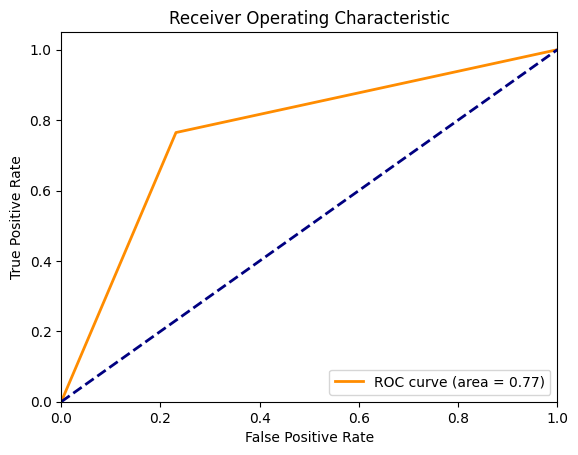

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Saving the trained model
model.save('trained_cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load and use the trained model
loaded_model = tf.keras.models.load_model('trained_cnn_model.h5')

In [ ]:
# Make predictions
def predict_sentiment(text):
    text = stemming(text)
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len)
    pred = loaded_model.predict(pad)
    return 'Positive Tweet' if pred[0][0] > 0.5 else 'Negative Tweet'

In [ ]:
# Example predictions
print(predict_sentiment(X_test.iloc[10000]))
print(predict_sentiment(X_test.iloc[300]))

1/1 [==============================] - 0s 96ms/step
Positive Tweet
1/1 [==============================] - 0s 97ms/step
Negative Tweet
